In [1]:
import pickle
import pandas as pd
import numpy as np
from IPython.display import Audio
import torch
import torchaudio
from IPython.display import Audio, display
import json
import os
from pathlib import Path


import pickle
import pandas as pd
import numpy as np
from IPython.display import Audio
import torch
import torchaudio
from IPython.display import Audio, display
import json
import os
from pathlib import Path
import shutil
from glob import glob



def get_df(exp_root, dir):
    exp_dir = Path(exp_root)/dir
    pkl_results_file = os.path.join(exp_dir, "measures.pickle")

    with open(pkl_results_file, "rb") as handle:
        dfme = pd.read_pickle(handle)
    return dfme


def get_df_storm(pkl_results_file, snr=None):
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_l/enhanced/storm_vbd/measures_storm.pickle"
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_k/enhanced/storm_TIMITChime3/measures_storm.pickle"
        # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_l/enhanced/sgmse_WSJ0Chime3/measures_storm.pickle"
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_k/enhanced/sgmse_TIMITChime3/measures_storm.pickle"
    with open(pkl_results_file, "rb") as handle:
        df2 = pd.read_pickle(handle)
    for i in range(len(df2["snr"])):
        df2.at[i, "snr"] = df2["snr"][i].split("_")[0]
    if snr is None:
        df_storm_ = df2.reset_index(drop=True).sort_values(by=['dir'])
    else:
        df_storm_ = df2[df2["snr"]==snr].reset_index(drop=True).sort_values(by=['dir'])
    return df_storm_


def write_results(df, name_alg,analysis_root,noises):
    df.to_excel(os.path.join(analysis_root, f"{name_alg}_all.xlsx"))
    for noisetype in noises:
        noise_mine  = df[df["noise_type"]==noisetype]
        noise_mine.to_excel(os.path.join(analysis_root, f"{name_alg}_{noisetype}.xlsx"))


def drop_rows_without_comparison(df, ours_df):
    for i in range(len(df["dir"])):
        dir_ = df["dir"][i]
        noisetype = df["noise_type"][i]
        mine_parallel = ours_df[(ours_df["dir"]==dir_) & (ours_df["noise_type"]==noisetype)]
        if len(mine_parallel)==0:
            idx = df[(df.dir==dir_)&(df.noise_type==noisetype)].index
            df = df.drop(idx)
        return df


def get_stats_df(df, alg_name, dir_=None, noise_type=None, snr_=None):
    if dir_:
        df = df[df["dir"]==dir_]
    if noise_type:
        df = df[df["noise_type"]==noise_type]
    if snr_:
        df = df[df["snr"]==snr_]
    dfstats = df.describe()[1:3]
    dfstats = dfstats.assign(alg=alg_name)
    return dfstats

In [3]:
import os
os.path.exists("/data")

True

In [9]:
def create_mine_df(exp_root,df_noisy,mine,noises,cols,names,snrs):
    for d in names: 
        if get_df(exp_root, d) is None:
            continue
        dfme = get_df(exp_root,d)
        dfme = dfme.assign(dir=d)
        cur_df_noisy = dfme[dfme["name"]=="noisy"].reset_index(drop=True)
        cur_df_noisy.loc[0,"dir"] = d
        if df_noisy is None:
            df_noisy = cur_df_noisy
        else:
            df_noisy = pd.concat([df_noisy, cur_df_noisy])
        dfme = dfme[dfme["name"] != "noisy"]
        
        dfme = dfme[dfme["stoi"]>0.5]

        for noisetype in noises :
            for c_snr in snrs:
                dfme_cur = dfme[dfme["snr"]==c_snr]
                cur_mine = dfme_cur[dfme_cur["noise_type"]==noisetype]
                cur_mine = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]
                if mine is None:
                    mine = cur_mine
                else:
                    mine = pd.concat([mine, cur_mine])
    mine=mine.reset_index(drop=True)
    return mine, df_noisy

In [2]:
from audio_tools2  import *
def calc_vad(f, verbose=False):
    test_file=f
    fs,s = read_wav(test_file)
    win_len = int(fs*0.025)
    hop_len = int(fs*0.010)
    sframes = enframe(s,win_len,hop_len) # rows: frame index, cols: each frame
    if verbose:
        plot_this(compute_log_nrg(sframes))

    # percent_high_nrg is the VAD context ratio. It helps smooth the
    # output VAD decisions. Higher values are more strict.
    percent_high_nrg = 0.5

    vad = nrg_vad(sframes,percent_high_nrg)

    if verbose:
        plot_these(deframe(vad,win_len,hop_len),s)
    return deframe(vad,win_len,hop_len) 

In [10]:
exp_root = "/data/ephraim/datasets/known_noise/undiff_exps/exp_m_long_ar_short/"
noises_names = ["1","2","3"]
snrs = ["5"]
names = ["j","b","c"]
    
storm_enhanced_path = str( Path(exp_root)/"storm/enhanced/")
storm_clean_wav = str(Path(exp_root)/"storm"/"clean_wav")
NOISES = noises_names

cols =["dir","name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
mine = None
df_noisy = None
mine, df_noisy = create_mine_df(exp_root,df_noisy,mine,noises=NOISES,cols=cols,names=names,snrs=snrs)

In [12]:
df_noisy[cols]

,dir,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,j,noisy,0.718182,0.718182,1.128445,1.128445,1.687658,2.848346,1.928565,7.426520,7.572649,7.572649,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,j,noisy,0.791407,0.791407,1.074102,1.074102,1.496310,2.460912,1.552840,7.421866,7.560651,7.560651,inf,2,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,j,noisy,0.966280,0.966280,1.092147,1.092147,2.156294,3.254030,2.446713,7.450538,7.576163,7.576163,inf,3,/data/ephraim/datasets/known_noise/undiff_exps...,5
0,b,noisy,0.862261,0.862261,1.153288,1.153288,1.463206,2.874097,1.419085,3.867025,4.024663,4.024663,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,b,noisy,0.891552,0.891552,1.141568,1.141568,1.578798,3.020575,1.414584,3.821966,4.013762,4.013762,inf,2,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,b,noisy,0.990842,0.990842,1.347888,1.347888,2.156353,3.202754,2.364667,3.775482,3.943384,3.943384,inf,3,/data/ephraim/datasets/known_noise/undiff_exps...,5
0,c,noisy,0.690134,0.690134,1.097542,1.097542,1.082347,1.202404,1.097192,5.775294,5.874004,5.874004,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,c,noisy,0.737474,0.737474,1.070969,1.070969,1.254547,1.789567,1.287516,5.787796,5.956243,5.956243,inf,2,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,c,noisy,0.923897,0.923897,1.105059,1.105059,2.034359,3.148100,2.209603,5.816817,5.947743,5.947743,inf,3,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [14]:
df_noisy.reset_index()[cols]["filename"][2]

'/data/ephraim/datasets/known_noise/undiff_exps/exp_m_long_ar_short/j/noisy_wav/noise3_digits_snr5_power0.00020307372324168682_var3.7328140024328604e-05.wav'

In [2]:
df = pd.read_excel("/data/ephraim/datasets/known_noise/undiff_exps/exp_m_long_ar_short/analysis/ours_all.xlsx")
df.head()

,Unnamed: 0,dir,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,0,j,s0.15,0.818631,0.718182,2.103537,1.128445,2.557314,3.326387,3.082553,12.780439,14.297867,14.297867,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,1,j,s0.15,0.852273,0.791407,2.322773,1.074102,2.621674,3.395552,3.156382,13.742191,15.485247,15.485247,inf,2,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,2,j,s0.28,0.921654,0.966280,3.224890,1.092147,2.737208,3.427277,3.230365,17.803297,18.909146,18.909146,inf,3,/data/ephraim/datasets/known_noise/undiff_exps...,5
3,3,b,s0.25,0.938810,0.862261,1.669572,1.153288,1.929850,3.076845,2.049949,8.981885,9.473524,9.473524,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5
4,4,b,s0.11,0.948716,0.891552,1.651828,1.141568,2.811823,3.261111,3.680640,11.353682,12.803010,12.803010,inf,2,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [ ]:
exp_root = "/data/ephraim/datasets/known_noise/undiff_exps/exp_m_long_ar_short/"
#find data relevant for finding s: 
for i in df.index.values:
    snr = df["snr"][i]
    noisetype = df["noise_type"][i]
    dir_ = df["dir"][i]
    s = float(df["name"][i].replace("s",""))
    wavpath = df["filename"][i]
    noisy_path = Path(exp_root) / dir_ / "noisy_wav" / Path(wavpath).name

    speech, sr = torchaudio.load(noisy_path)
    vaded_signal = calc_vad(noisy_path)[0:speech.shape[1],:]
    vaded_signal_torch = (speech[0][vaded_signal.T[0]>0])
    vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
    clean_power = float( 1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2))
    simple_power =  float(1 / speech.shape[1] * torch.sum(speech**2))
    vaded_rate = (vaded_signal_torch.shape[1]/speech.shape[1])
    variance = float( torch.var(speech, unbiased=True))
    df.at[i, "clean_power"] = clean_power
    df.at[i, "simple_power"] = simple_power
    df.at[i, "vaded_rate"] = vaded_rate
    df.at[i, "variance"] = variance
    
    # name = f"{dir_}_{noisetype}_snr{snr}_{algname}.wav"
    # dst = wavdst/f"{name}"
    # print("origin:", wavpath)
    # print("dst:", dst)

In [42]:
df


,Unnamed: 0,dir,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,...,sdr,sar,sir,noise_type,filename,snr,clean_power,simple_power,vaded_rate,variance
0,0,j,s0.15,0.818631,0.718182,2.103537,1.128445,2.557314,3.326387,3.082553,...,14.297867,14.297867,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.002216,0.00132,0.51,0.001319
1,1,j,s0.15,0.852273,0.791407,2.322773,1.074102,2.621674,3.395552,3.156382,...,15.485247,15.485247,inf,2,/data/ephraim/datasets/known_noise/undiff_exps...,5,NaN,NaN,NaN,NaN
2,2,j,s0.28,0.921654,0.966280,3.224890,1.092147,2.737208,3.427277,3.230365,...,18.909146,18.909146,inf,3,/data/ephraim/datasets/known_noise/undiff_exps...,5,NaN,NaN,NaN,NaN
3,3,b,s0.25,0.938810,0.862261,1.669572,1.153288,1.929850,3.076845,2.049949,...,9.473524,9.473524,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5,NaN,NaN,NaN,NaN
4,4,b,s0.11,0.948716,0.891552,1.651828,1.141568,2.811823,3.261111,3.680640,...,12.803010,12.803010,inf,2,/data/ephraim/datasets/known_noise/undiff_exps...,5,NaN,NaN,NaN,NaN
5,5,b,s0.11,0.981452,0.990842,1.908331,1.347888,2.404199,3.123708,3.115058,...,17.546651,17.546651,inf,3,/data/ephraim/datasets/known_noise/undiff_exps...,5,NaN,NaN,NaN,NaN
6,6,c,s0.11,0.855375,0.690134,1.997323,1.097542,2.094828,2.734516,3.075452,...,13.672695,13.672695,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5,NaN,NaN,NaN,NaN
7,7,c,s0.09,0.844528,0.737474,1.937932,1.070969,2.459490,2.921823,3.575061,...,14.670455,14.670455,inf,2,/data/ephraim/datasets/known_noise/undiff_exps...,5,NaN,NaN,NaN,NaN
8,8,c,s0.08,0.883186,0.923897,1.962855,1.105059,2.467041,2.840050,3.598132,...,18.982143,18.982143,inf,3,/data/ephraim/datasets/known_noise/undiff_exps...,5,NaN,NaN,NaN,NaN


In [36]:
noise_path = "/data/ephraim/datasets/known_noise/undiff_exps/exp_m_long_ar_short/c/noisy_wav/noise3_digits_snr5_power0.001966120209544897_var0.00036140374140813947.wav"
speech, sr = torchaudio.load(noise_path)
vaded_signal = calc_vad(noise_path)[0:speech.shape[1],:]
vaded_signal_torch = (speech[0][vaded_signal.T[0]>0])
vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
clean_power = float( 1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2))
print("clean_power: ", clean_power)
simple_power =  float(1 / speech.shape[1] * torch.sum(speech**2))
print("simple_power: ", simple_power)
vaded_rate = (vaded_signal_torch.shape[1]/speech.shape[1])
print(vaded_rate)
variance = torch.var(speech, unbiased=True)
print(variance)

clean_power:  0.013735100626945496
simple_power:  0.009470024146139622
0.565
tensor(0.0095)


In [33]:
(vaded_signal_torch.shape[1]/speech.shape[1])

0.565

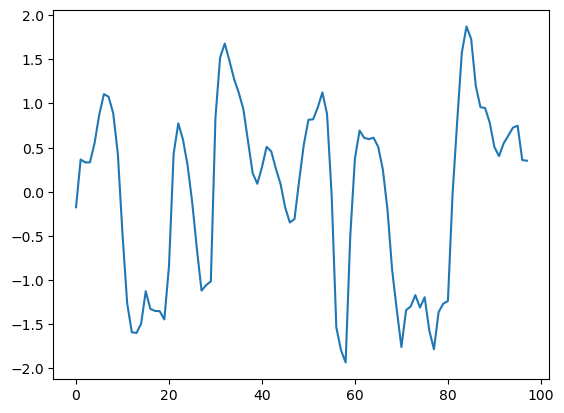

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


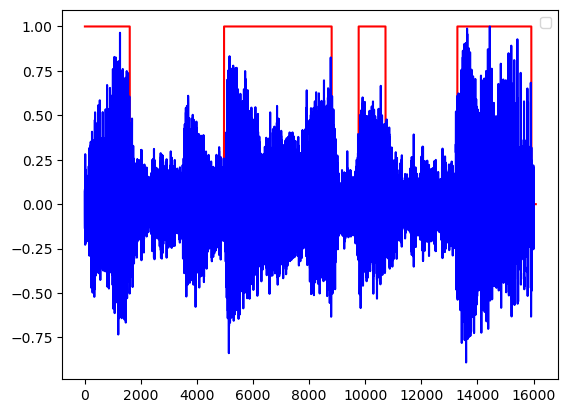

In [25]:
vaded_signal = calc_vad(noise_path, verbose=True)

In [26]:
from IPython.display import Audio, display

display(Audio(noise_path, rate=16000, autoplay=False))

In [6]:
from IPython.display import Audio, display

noise_path = "/data/ephraim/datasets/dns_test/no_reverb/noises/clnsp67_air_conditioner_151977_0_snr18_tl-23_fileid_80.wav"
display(Audio(noise_path, rate=16000, autoplay=False))

In [7]:
#### Display tools
def plot_this(s,title=''):
    """

    """
    import pylab
    s = s.squeeze()
    if s.ndim ==1:
        pylab.plot(s)
    else:
        pylab.imshow(s,aspect='auto')
        pylab.title(title)
    pylab.show()
    
plot_this

<function __main__.plot_this(s, title='')>

In [9]:
ar_noise2.shape

torch.Size([1, 160000])

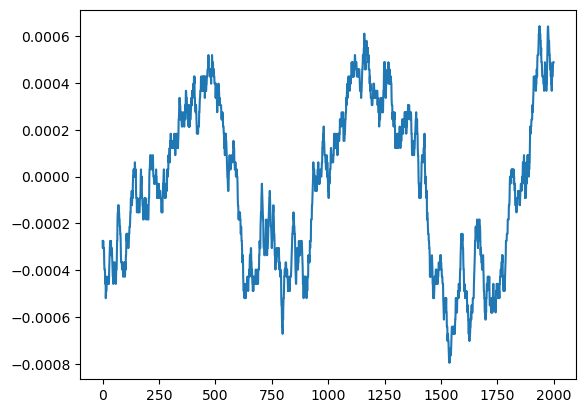

In [11]:
ar_noise2, sr = torchaudio.load(noise_path)
plot_this(ar_noise2[:,1000:3000])

In [23]:
import json
from collections import Counter

def analyze_stationarity_results(json_file):
    """
    Load the JSON file and display statistics for 'stationary' results.

    Args:
        json_file (str): Path to the JSON file containing stationarity results.

    Returns:
        None
    """
    try:
        # Load the JSON file
        with open(json_file, "r") as f:
            results = json.load(f)
        
        # Extract 'stationary' values
        stationary_values = [
            entry["stationary"] for entry in results.values() if "stationary" in entry
        ]

        # Count True/False occurrences
        counts = Counter(stationary_values)

        # Print statistics
        print("Stationarity Statistics:")
        print(f"True: {counts.get(True, 0)}")
        print(f"False: {counts.get(False, 0)}")

    except Exception as e:
        print(f"Error: {e}")

# Example usage
json_file_path = "/data/ephraim/datasets/DNS-Challenge_old/synth_exp_n/stationarity_results.json"  # Replace with your JSON file path
analyze_stationarity_results(json_file_path)

Stationarity Statistics:
True: 11
False: 25
